## Imports

In [48]:
import os
import wandb

wandb.init(project="image-similarity-search", entity="ajwadakil")
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import os
import torch.nn.functional as F
from PIL import Image
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os
import pandas as pd
import numpy as np
import albumentations
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import torchvision.transforms as T
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

wandb: Currently logged in as: ajwadakil (use `wandb login --relogin` to force relogin)


## Torch Cuda Version

In [49]:
print(torch.__version__)
print(torch.cuda.get_device_name(0))
torch.cuda.empty_cache()

1.10.0+cu113
NVIDIA GeForce RTX 3060 Laptop GPU


In [50]:
# def handle_dataset():
#     transform = torchvision.transforms.ToTensor()
#     caltech256 = torchvision.datasets.Caltech256(root='./data', download=True, transform=transform)
#
#     # train_dataset, val_dataset = torch.utils.data.random_split(caltech256, [0.75, 0.25])
#
#     # # Create the train dataloader
#     # train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
#
#     # # Create the validation dataloader
#     # val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
#
#     # # Create the full dataloader
#     # full_loader = torch.utils.data.DataLoader(caltech256, batch_size=32, shuffle=True)
#     # #data_loader = torch.utils.data.DataLoader(dataset=caltech256, batch_size=64, shuffle=True)
#
#     return train_loader, val_loader, full_loader

In [51]:
root_dir = './data/caltech256/256_ObjectCategories'
# get all the folder paths
all_paths = os.listdir(root_dir)

# create a DataFrame
data = pd.DataFrame()

images = []
labels = []
counter = 0
for folder_path in tqdm(all_paths, total=len(all_paths)):
    # get all the image names in the particular folder
    image_paths = os.listdir(f"{root_dir}/{folder_path}")
    # get the folder as label
    label = folder_path.split('.')[-1]

    if label == 'clutter':
        continue

    # save image paths in the DataFrame
    for image_path in image_paths:
        if image_path.split('.')[-1] == 'jpg':
            data.loc[counter, 'image_path'] = f"{root_dir}/{folder_path}/{image_path}"
            labels.append(label)
            counter += 1

labels = np.array(labels)
# one-hot encode the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# add the image labels to the dataframe
for i in range(len(labels)):
    index = np.argmax(labels[i])
    data.loc[i, 'target'] = int(index)

# # shuffle the dataset
# data = data.sample(frac=1).reset_index(drop=True)

print(f"Number of labels or classes: {len(lb.classes_)}")
print(f"The first one hot encoded labels: {labels[0]}")
print(f"Mapping the first one hot encoded label to its category: {lb.classes_[0]}")
print(f"Total instances: {len(data)}")

# save as CSV file
data.to_csv('data.csv', index=False)

print(data.head(5))

100%|██████████| 257/257 [00:25<00:00, 10.24it/s]


Number of labels or classes: 256
The first one hot encoded labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Mapping the first one hot encoded label to its category: airplanes-101
Total instances: 29780
                                          image_path  target
0  ./data/caltech256/256_ObjectCategories/064.ele...    65.0
1  ./data/caltech256/256_ObjectCategories/064.ele...    65.0
2  ./data/caltech256/256_ObjectCategories/064.ele...    65.0
3  ./data/caltech256/256_ObjectCategories/064.ele...    65.0
4  ./data/calt

## Custom Dataset Class

In [52]:
# custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, tfms=None):
        self.X = images
        self.y = labels

        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                #albumentations.Normalize(mean=(140.9288, 136.0920, 129.1500), std=(81.2744, 80.3511, 83.7452), p=1.0)
                albumentations.Normalize()
                #albumentations.Normalize(mean=(0.2934, 0.3437, 0.4428), std=(1.3826, 1.3972, 1.4503), p=1.0)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.HorizontalFlip(p=0.5),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.3,
                    scale_limit=0.3,
                    rotate_limit=15,
                    p=0.5
                ),
                #albumentations.Normalize(mean=(0.2934, 0.3437, 0.4428), std=(1.3826, 1.3972, 1.4503), p=1.0)
                albumentations.Normalize()
                #albumentations.Normalize(mean=(140.9288, 136.0920, 129.1500), std=(81.2744, 80.3511, 83.7452), p=1.0)
            ])
         
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = image.convert('RGB')
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            'image_X': torch.tensor(image, dtype=torch.float), 
            'image_Y': torch.tensor(image, dtype=torch.float)
        }

In [53]:
# get the dataset ready
df = pd.read_csv('data.csv')
X = df.image_path.values # image paths
y = df.target.values # targets
batch_size = 32

(xtrain, x_val_test, ytrain, y_val_test) = train_test_split(X, y,
	test_size=0.10, random_state=79)

(x_val, x_test, y_val, y_test) = train_test_split(x_val_test, y_val_test,
    test_size=0.5, random_state=81)
    
print(f"Training instances: {len(xtrain)}")
print(f"Validation instances: {len(x_val)}")
print(f"Testing instances: {len(x_test)}")

train_data = ImageDataset(xtrain, ytrain, tfms=1)
validation_data = ImageDataset(x_val, y_val, tfms=0)
test_data = ImageDataset(x_val, y_val, tfms=0)
full_dataset = ImageDataset(X, y, tfms=0)

# dataloaders
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
full_dataset_data_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

Training instances: 26802
Validation instances: 1489
Testing instances: 1489


In [54]:
# computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [55]:
def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data_index, data in enumerate(loader):
        X, Y = data['image_X'].to(device), data['image_Y'].to(device)
        channels_sum += torch.mean(X, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(X ** 2, dim=[0, 2, 3])
        num_batches += 1

    print('num of batches:', num_batches)

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


train_mean, train_std = get_mean_std(train_data_loader)

print(train_mean)
print(train_std)


num of batches: 838
tensor([0.2941, 0.3442, 0.4430], device='cuda:0')
tensor([1.3823, 1.3968, 1.4501], device='cuda:0')


In [56]:
for data_index, data in enumerate(train_data_loader):
    X, Y = data['image_X'].to(device), data['image_Y'].to(device)
    print(X.shape)
    np_arr = X.detach().cpu().numpy()
    np_arr_2 = Y.detach().cpu().numpy()
    img = Image.fromarray(np_arr[0], 'RGB')
    img.save('myssss.png')
    img.show()
    break

torch.Size([32, 3, 224, 224])


In [57]:
class SimpleConvolutionEncoder(nn.Module):
    """
    Simple convolution encoder implementation
    """

    def __init__(self):
        super().__init__()

        self.conv2D_1, self.relu_1, self.maxpool_1 = self.convolve_unit(
            in_channels_=3,
            out_channels_=16,
            conv_kernel_size=(3,3),
            padding_=(1,1),
            conv_stride=(1,1),
            pool_kernel_size=(2,2),
            pool_stride=(2,2)
        )

        self.conv2D_2, self.relu_2, self.maxpool_2 = self.convolve_unit(
            in_channels_=16,
            out_channels_=32,
            conv_kernel_size=(3,3),
            padding_=(1,1),
            conv_stride=(1,1),
            pool_kernel_size=(2,2),
            pool_stride=(2,2)
        )

        self.conv2D_3, self.relu_3, self.maxpool_3 = self.convolve_unit(
            in_channels_=32,
            out_channels_=64,
            conv_kernel_size=(3,3),
            padding_=(1,1),
            conv_stride=(1,1),
            pool_kernel_size=(2,2),
            pool_stride=(2,2)
        )

        self.conv2D_4, self.relu_4, self.maxpool_4 = self.convolve_unit(
            in_channels_=64,
            out_channels_=128,
            conv_kernel_size=(3,3),
            padding_=(1,1),
            conv_stride=(1,1),
            pool_kernel_size=(2,2),
            pool_stride=(2,2)
        )


    @staticmethod
    def convolve_unit( in_channels_, out_channels_, conv_kernel_size, padding_, conv_stride, pool_kernel_size, pool_stride):
        conv2D_layer = nn.Conv2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=conv_kernel_size, padding=padding_, stride=conv_stride)
        relu_activation = nn.ReLU(inplace=True)
        maxpool_layer = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        return conv2D_layer, relu_activation, maxpool_layer

    @staticmethod
    def convolve_batch_norm_unit( in_channels_, out_channels_, conv_kernel_size, padding_, conv_stride, pool_kernel_size, pool_stride):
        conv2D_layer = nn.Conv2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=conv_kernel_size, padding=padding_, stride=conv_stride)
        batch_norm_layer = nn.BatchNorm2d(num_features=out_channels_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        relu_activation = nn.ReLU(inplace=True)
        maxpool_layer = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        return conv2D_layer,batch_norm_layer, relu_activation, maxpool_layer


    @staticmethod
    def convolve_leaky_relu_unit( in_channels_, out_channels_, conv_kernel_size, padding_, conv_stride, pool_kernel_size, pool_stride):
        conv2D_layer = nn.Conv2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=conv_kernel_size, padding=padding_, stride=conv_stride)
        leaky_relu_activation = nn.LeakyReLU(inplace=True)
        maxpool_layer = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        return conv2D_layer, leaky_relu_activation, maxpool_layer

    @staticmethod
    def convolve_leaky_relu_batch_norm_unit( in_channels_, out_channels_, conv_kernel_size, padding_, conv_stride, pool_kernel_size, pool_stride):
        conv2D_layer = nn.Conv2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=conv_kernel_size, padding=padding_, stride=conv_stride)
        batch_norm_layer = nn.BatchNorm2d(num_features=out_channels_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        leaky_relu_activation = nn.LeakyReLU(inplace=True)
        maxpool_layer = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        return conv2D_layer, batch_norm_layer, leaky_relu_activation, maxpool_layer

    def forward(self, x):
        # we first downscale the image by repeated convolutions
        x = self.conv2D_1(x) # 3, 224, 244 ---> 16, 224, 224
        #print('After convolving:', x.size())
        x = self.relu_1(x)
        x = self.maxpool_1(x) # 16, 224, 224 ---> 16, 222, 222
        #print('After maxpool:', x.size())

        x = self.conv2D_2(x) # 16, 222, 222 ---> 32, 222, 222
        #print('After convolving:', x.size())
        x = self.relu_2(x)
        x = self.maxpool_2(x) # 32, 222, 222 ---> 32, 220, 220
        #print('After maxpool:', x.size())

        x = self.conv2D_3(x) # 32, 219, 219 ---> 64, 220, 220
        #print('After convolving:', x.size())
        x = self.relu_3(x)
        x = self.maxpool_3(x) # 64, 219, 219 ---> 64, 110, 110
        #print('After maxpool:', x.size())

        x = self.conv2D_4(x) # 64, 110, 110 ---> 128, 108, 108
        #print('After convolving:', x.size())
        x = self.relu_4(x)
        x = self.maxpool_4(x) # 128, 108, 108 ---> N, 128, 14, 14
        #print('After maxpool:', x.size())

        # print(f'After linear layer:{x.size()}')
        return x

In [58]:
class SimpleConvolutionEncoderBatchNorm(nn.Module):
    """
    Simple convolution encoder implementation
    """

    def __init__(self):
        super().__init__()

        self.conv2D_1, self.batch_norm2D_1, self.relu_1, self.maxpool_1 = self.convolve_batch_norm_unit(
            in_channels_=3,
            out_channels_=16,
            conv_kernel_size=(3,3),
            padding_=(1,1),
            conv_stride=(1,1),
            pool_kernel_size=(2,2),
            pool_stride=(2,2)
        )

        self.conv2D_2, self.batch_norm2D_2, self.relu_2, self.maxpool_2 = self.convolve_batch_norm_unit(
            in_channels_=16,
            out_channels_=32,
            conv_kernel_size=(3,3),
            padding_=(1,1),
            conv_stride=(1,1),
            pool_kernel_size=(2,2),
            pool_stride=(2,2)
        )

        self.conv2D_3, self.batch_norm2D_3, self.relu_3, self.maxpool_3 = self.convolve_batch_norm_unit(
            in_channels_=32,
            out_channels_=64,
            conv_kernel_size=(3,3),
            padding_=(1,1),
            conv_stride=(1,1),
            pool_kernel_size=(2,2),
            pool_stride=(2,2)
        )

        self.conv2D_4, self.batch_norm2D_4, self.relu_4, self.maxpool_4 = self.convolve_batch_norm_unit(
            in_channels_=64,
            out_channels_=128,
            conv_kernel_size=(3,3),
            padding_=(1,1),
            conv_stride=(1,1),
            pool_kernel_size=(2,2),
            pool_stride=(2,2)
        )

        self.flatten = nn.Flatten()

        # # newly added
        self.linear_1 = nn.Linear(in_features=25088, out_features=1024)
        self.linear_batch_norm1D = nn.BatchNorm1d(num_features=1024, momentum=0.01)
        self.relu = nn.ReLU(inplace=True)

    @staticmethod
    def convolve_unit( in_channels_, out_channels_, conv_kernel_size, padding_, conv_stride, pool_kernel_size, pool_stride):
        conv2D_layer = nn.Conv2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=conv_kernel_size, padding=padding_, stride=conv_stride)
        relu_activation = nn.ReLU(inplace=True)
        maxpool_layer = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        return conv2D_layer, relu_activation, maxpool_layer

    @staticmethod
    def convolve_batch_norm_unit( in_channels_, out_channels_, conv_kernel_size, padding_, conv_stride, pool_kernel_size, pool_stride):
        conv2D_layer = nn.Conv2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=conv_kernel_size, padding=padding_, stride=conv_stride)
        batch_norm_layer = nn.BatchNorm2d(num_features=out_channels_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        relu_activation = nn.ReLU(inplace=True)
        maxpool_layer = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        return conv2D_layer,batch_norm_layer, relu_activation, maxpool_layer


    @staticmethod
    def convolve_leaky_relu_unit( in_channels_, out_channels_, conv_kernel_size, padding_, conv_stride, pool_kernel_size, pool_stride):
        conv2D_layer = nn.Conv2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=conv_kernel_size, padding=padding_, stride=conv_stride)
        leaky_relu_activation = nn.LeakyReLU(inplace=True)
        maxpool_layer = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        return conv2D_layer, leaky_relu_activation, maxpool_layer

    @staticmethod
    def convolve_leaky_relu_batch_norm_unit( in_channels_, out_channels_, conv_kernel_size, padding_, conv_stride, pool_kernel_size, pool_stride):
        conv2D_layer = nn.Conv2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=conv_kernel_size, padding=padding_, stride=conv_stride)
        batch_norm_layer = nn.BatchNorm2d(num_features=out_channels_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        leaky_relu_activation = nn.LeakyReLU(inplace=True)
        maxpool_layer = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        return conv2D_layer, batch_norm_layer, leaky_relu_activation, maxpool_layer

    def forward(self, x):
        # we first downscale the image by repeated convolutions
        x = self.conv2D_1(x) # 3, 224, 244 ---> 16, 224, 224
        #print('After convolving:', x.size())
        x = self.batch_norm2D_1(x)
        x = self.relu_1(x)
        x = self.maxpool_1(x) # 16, 224, 224 ---> 16, 222, 222
        #print('After maxpool:', x.size())

        x = self.conv2D_2(x) # 16, 222, 222 ---> 32, 222, 222
        #print('After convolving:', x.size())
        x = self.batch_norm2D_2(x)
        x = self.relu_2(x)
        x = self.maxpool_2(x) # 32, 222, 222 ---> 32, 220, 220
        #print('After maxpool:', x.size())

        x = self.conv2D_3(x) # 32, 219, 219 ---> 64, 220, 220
        #print('After convolving:', x.size())
        x = self.batch_norm2D_3(x)
        x = self.relu_3(x)
        x = self.maxpool_3(x) # 64, 219, 219 ---> 64, 110, 110
        #print('After maxpool:', x.size())

        x = self.conv2D_4(x) # 64, 110, 110 ---> 128, 108, 108
        #print('After convolving:', x.size())
        x = self.batch_norm2D_4(x)
        x = self.relu_4(x)
        x = self.maxpool_4(x) # 128, 108, 108 ---> N, 128, 14, 14
        #print('After maxpool:', x.size())

        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.linear_batch_norm1D(x)
        x = self.relu(x)
        # print(f'After linear layer:{x.size()}')
        return x

In [59]:
class ResnetEncoder(nn.Module):
    def __init__(self):
        super(ResnetEncoder, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        self.fc1 = nn.Linear(resnet.fc.in_features, 1024) # in_feature = 2048
        self.bn1 = nn.BatchNorm1d(1024, momentum=0.01)
        self.fc2 = nn.Linear(1024, 768)
        self.bn2 = nn.BatchNorm1d(768, momentum=0.01)
        self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        print(f'The last layers shape: {x.size()}')

In [60]:
class SimpleConvolutionEncoderLR(nn.Module):
    """
    Simple convolution encoder implementation
    """

    def __init__(self):
        super().__init__()

        self.conv2D_1, self.relu_1, self.maxpool_1 = self.convolve_leaky_relu_unit(
            in_channels_=3,
            out_channels_=16,
            conv_kernel_size=(3,3),
            padding_=(1,1),
            conv_stride=(1,1),
            pool_kernel_size=(2,2),
            pool_stride=(2,2)
        )

        self.conv2D_2, self.relu_2, self.maxpool_2 = self.convolve_leaky_relu_unit(
            in_channels_=16,
            out_channels_=32,
            conv_kernel_size=(3,3),
            padding_=(1,1),
            conv_stride=(1,1),
            pool_kernel_size=(2,2),
            pool_stride=(2,2)
        )

        self.conv2D_3, self.relu_3, self.maxpool_3 = self.convolve_leaky_relu_unit(
            in_channels_=32,
            out_channels_=64,
            conv_kernel_size=(3,3),
            padding_=(1,1),
            conv_stride=(1,1),
            pool_kernel_size=(2,2),
            pool_stride=(2,2)
        )

        self.conv2D_4, self.relu_4, self.maxpool_4 = self.convolve_leaky_relu_unit(
            in_channels_=64,
            out_channels_=128,
            conv_kernel_size=(3,3),
            padding_=(1,1),
            conv_stride=(1,1),
            pool_kernel_size=(2,2),
            pool_stride=(2,2)
        )

        # # newly added
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(in_features=25088, out_features=1024)
        self.linear_batch_norm1D = nn.BatchNorm1d(num_features=1024, momentum=0.01)
        self.relu = nn.ReLU(inplace=True)


    @staticmethod
    def convolve_unit( in_channels_, out_channels_, conv_kernel_size, padding_, conv_stride, pool_kernel_size, pool_stride):
        conv2D_layer = nn.Conv2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=conv_kernel_size, padding=padding_, stride=conv_stride)
        relu_activation = nn.ReLU(inplace=True)
        maxpool_layer = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        return conv2D_layer, relu_activation, maxpool_layer

    @staticmethod
    def convolve_batch_norm_unit( in_channels_, out_channels_, conv_kernel_size, padding_, conv_stride, pool_kernel_size, pool_stride):
        conv2D_layer = nn.Conv2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=conv_kernel_size, padding=padding_, stride=conv_stride)
        batch_norm_layer = nn.BatchNorm2d(num_features=out_channels_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        relu_activation = nn.ReLU(inplace=True)
        maxpool_layer = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        return conv2D_layer,batch_norm_layer, relu_activation, maxpool_layer


    @staticmethod
    def convolve_leaky_relu_unit( in_channels_, out_channels_, conv_kernel_size, padding_, conv_stride, pool_kernel_size, pool_stride):
        conv2D_layer = nn.Conv2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=conv_kernel_size, padding=padding_, stride=conv_stride)
        leaky_relu_activation = nn.LeakyReLU(inplace=True)
        maxpool_layer = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        return conv2D_layer, leaky_relu_activation, maxpool_layer

    @staticmethod
    def convolve_leaky_relu_batch_norm_unit( in_channels_, out_channels_, conv_kernel_size, padding_, conv_stride, pool_kernel_size, pool_stride):
        conv2D_layer = nn.Conv2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=conv_kernel_size, padding=padding_, stride=conv_stride)
        batch_norm_layer = nn.BatchNorm2d(num_features=out_channels_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        leaky_relu_activation = nn.LeakyReLU(inplace=True)
        maxpool_layer = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        return conv2D_layer, batch_norm_layer, leaky_relu_activation, maxpool_layer

    def forward(self, x):
        # we first downscale the image by repeated convolutions
        x = self.conv2D_1(x) # 3, 224, 244 ---> 16, 224, 224
        #print('After convolving:', x.size())
        x = self.maxpool_1(x)
        x = self.relu_1(x)
        # 16, 224, 224 ---> 16, 222, 222
        #print('After maxpool:', x.size())

        x = self.conv2D_2(x) # 16, 222, 222 ---> 32, 222, 222
        #print('After convolving:', x.size())
        x = self.maxpool_2(x) # 32, 222, 222 ---> 32, 220, 220
        x = self.relu_2(x)
        #print('After maxpool:', x.size())

        x = self.conv2D_3(x) # 32, 219, 219 ---> 64, 220, 220
        #print('After convolving:', x.size())
        x = self.maxpool_3(x) # 64, 219, 219 ---> 64, 110, 110
        x = self.relu_3(x)
        #print('After maxpool:', x.size())

        x = self.conv2D_4(x) # 64, 110, 110 ---> 128, 108, 108
        #print('After convolving:', x.size())
        x = self.maxpool_4(x) # 128, 108, 108 ---> N, 128, 14, 14
        x = self.relu_4(x)
        #print('After maxpool:', x.size())


        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.linear_batch_norm1D(x)
        x = self.relu(x)

        # print(f'After linear layer:{x.size()}')
        return x

Encoder Model converts a single Image of shape (3, 224, 224) to a feature map of shape (128, 53, 53) for the time being. This hidden representation will be forwarded to the the decoder model

In [61]:
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 100,
    "batch_size": 32
}

In [62]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

## Simple Convolution Decoder

In [63]:
class SimpleConvolutionDecoder(nn.Module):
    """
    Simple convolution decoder implementation
    """

    def __init__(self):
        super().__init__()

        self.linear_1 = nn.Linear(in_features=1024, out_features=25088)
        self.linear_batch_norm1D = nn.BatchNorm1d(num_features=25088, momentum=0.01)
        self.relu = nn.ReLU(inplace=True)

        self.reshape = Reshape(-1, 128, 14, 14)

        self.deconv2D_1,  self.relu_1 = self.deconvolve_unit(
            in_channels_=128,
            out_channels_=64,
            deconv_kernel_size=(2,2),
            stride_=(2,2),
        )

        self.deconv2D_2,  self.relu_2 = self.deconvolve_unit(
            in_channels_=64,
            out_channels_=32,
            deconv_kernel_size=(2,2),
            stride_=(2,2),
        )

        self.deconv2D_3,  self.relu_3 = self.deconvolve_unit(
            in_channels_=32,
            out_channels_=16,
            deconv_kernel_size=(2,2),
            stride_=(2,2),
        )

        self.deconv2D_4,  self.relu_4 = self.deconvolve_unit(
            in_channels_=16,
            out_channels_=3,
            deconv_kernel_size=(2,2),
            stride_=(2,2),
        )

    @staticmethod
    def deconvolve_unit(in_channels_, out_channels_, deconv_kernel_size, stride_):
        deconvolution_layer = nn.ConvTranspose2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=deconv_kernel_size, stride=stride_)

        relu_activation = nn.ReLU(inplace=True)

        return deconvolution_layer, relu_activation

    @staticmethod
    def deconvolve_leaky_relu_unit(in_channels_, out_channels_, deconv_kernel_size, stride_):
        deconvolution_layer = nn.ConvTranspose2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=deconv_kernel_size, stride=stride_)

        leaky_relu_activation = nn.LeakyReLU(inplace=True)

        return deconvolution_layer, leaky_relu_activation

    @staticmethod
    def deconvolve_batch_norm_leaky_relu_unit(in_channels_, out_channels_, deconv_kernel_size, stride_):
        deconvolution_layer = nn.ConvTranspose2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=deconv_kernel_size, stride=stride_)
        batch_norm_layer = nn.BatchNorm2d(num_features=out_channels_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        relu_activation = nn.LeakyReLU(inplace=True)

        return deconvolution_layer, batch_norm_layer, relu_activation


    @staticmethod
    def deconvolve_batch_norm_unit(in_channels_, out_channels_, deconv_kernel_size, stride_):
        deconvolution_layer = nn.ConvTranspose2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=deconv_kernel_size, stride=stride_)
        batch_norm_layer = nn.BatchNorm2d(num_features=out_channels_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        relu_activation = nn.ReLU(inplace=True)

        return deconvolution_layer, batch_norm_layer, relu_activation



    def forward(self, x):
        # we first downscale the image by repeated convolutions
        # print('Before Deconvolution: ', x.size())
        x = self.linear_1(x)
        # print('here')
        x = self.linear_batch_norm1D(x)
        x = self.relu(x)

        x = self.reshape(x)

        # print(f'Reshaping to:{x.size()}')

        x = self.deconv2D_1(x) #
        #print('After deconvolving:', x.size())
        x = self.relu_1(x)

        x = self.deconv2D_2(x) # 16, 222, 222 ---> 32, 222, 222
        #print('After deconvolving:', x.size())
        x = self.relu_2(x)

        x = self.deconv2D_3(x) # 32, 219, 219 ---> 64, 220, 220
        #print('After deconvolving:', x.size())
        x = self.relu_3(x)

        x = self.deconv2D_4(x) # 64, 110, 110 ---> 128, 108, 108
        #print('After deconvolving:', x.size())
        x = self.relu_4(x)

        return x

## Decoder Batch Norm

In [64]:
class SimpleConvolutionDecoderBatchNorm(nn.Module):
    """
    Simple convolution decoder implementation
    """

    def __init__(self):
        super().__init__()

        self.linear_1 = nn.Linear(in_features=1024, out_features=25088)
        self.linear_batch_norm1D = nn.BatchNorm1d(num_features=25088, momentum=0.01)
        self.relu = nn.ReLU(inplace=True)

        self.reshape = Reshape(-1, 128, 14, 14)

        self.deconv2D_1, self.batch_norm2D_1, self.relu_1 = self.deconvolve_batch_norm_unit(
            in_channels_=128,
            out_channels_=64,
            deconv_kernel_size=(2,2),
            stride_=(2,2),
        )

        self.deconv2D_2, self.batch_norm2D_2, self.relu_2 = self.deconvolve_batch_norm_unit(
            in_channels_=64,
            out_channels_=32,
            deconv_kernel_size=(2,2),
            stride_=(2,2),
        )

        self.deconv2D_3, self.batch_norm2D_3, self.relu_3 = self.deconvolve_batch_norm_unit(
            in_channels_=32,
            out_channels_=16,
            deconv_kernel_size=(2,2),
            stride_=(2,2),
        )

        self.deconv2D_4, self.batch_norm2D_4, self.relu_4 = self.deconvolve_batch_norm_unit(
            in_channels_=16,
            out_channels_=3,
            deconv_kernel_size=(2,2),
            stride_=(2,2),
        )

    @staticmethod
    def deconvolve_unit(in_channels_, out_channels_, deconv_kernel_size, stride_):
        deconvolution_layer = nn.ConvTranspose2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=deconv_kernel_size, stride=stride_)

        relu_activation = nn.ReLU(inplace=True)

        return deconvolution_layer, relu_activation

    @staticmethod
    def deconvolve_leaky_relu_unit(in_channels_, out_channels_, deconv_kernel_size, stride_):
        deconvolution_layer = nn.ConvTranspose2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=deconv_kernel_size, stride=stride_)

        leaky_relu_activation = nn.LeakyReLU(inplace=True)

        return deconvolution_layer, leaky_relu_activation

    @staticmethod
    def deconvolve_batch_norm_leaky_relu_unit(in_channels_, out_channels_, deconv_kernel_size, stride_):
        deconvolution_layer = nn.ConvTranspose2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=deconv_kernel_size, stride=stride_)
        batch_norm_layer = nn.BatchNorm2d(num_features=out_channels_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        relu_activation = nn.LeakyReLU(inplace=True)

        return deconvolution_layer, batch_norm_layer, relu_activation


    @staticmethod
    def deconvolve_batch_norm_unit(in_channels_, out_channels_, deconv_kernel_size, stride_):
        deconvolution_layer = nn.ConvTranspose2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=deconv_kernel_size, stride=stride_)
        batch_norm_layer = nn.BatchNorm2d(num_features=out_channels_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        relu_activation = nn.ReLU(inplace=True)

        return deconvolution_layer, batch_norm_layer, relu_activation



    def forward(self, x):
        # we first downscale the image by repeated convolutions
        # print('Before Deconvolution: ', x.size())
        x = self.linear_1(x)
        # print('here')
        x = self.linear_batch_norm1D(x)
        x = self.relu(x)

        x = self.reshape(x)

        # print(f'Reshaping to:{x.size()}')

        x = self.deconv2D_1(x) #
        x = self.batch_norm2D_1(x)
        #print('After deconvolving:', x.size())
        x = self.relu_1(x)

        x = self.deconv2D_2(x) # 16, 222, 222 ---> 32, 222, 222
        #print('After deconvolving:', x.size())
        x = self.batch_norm2D_2(x)
        x = self.relu_2(x)

        x = self.deconv2D_3(x) # 32, 219, 219 ---> 64, 220, 220
        #print('After deconvolving:', x.size())
        x = self.batch_norm2D_3(x)
        x = self.relu_3(x)

        x = self.deconv2D_4(x) # 64, 110, 110 ---> 128, 108, 108
        x = self.batch_norm2D_4(x)
        #print('After deconvolving:', x.size())
        x = self.relu_4(x)

        return x

## Decoder Leaky Relu

In [65]:
class SimpleConvolutionDecoderLR(nn.Module):
    """
    Simple convolution decoder implementation
    """

    def __init__(self):
        super().__init__()


        self.linear_1 = nn.Linear(in_features=1024, out_features=25088)
        self.linear_batch_norm1D = nn.BatchNorm1d(num_features=25088, momentum=0.01)
        self.relu = nn.ReLU(inplace=True)

        self.reshape = Reshape(-1, 128, 14, 14)

        self.deconv2D_1, self.relu_1 = self.deconvolve_leaky_relu_unit(
            in_channels_=128,
            out_channels_=64,
            deconv_kernel_size=(2,2),
            stride_=(2,2),
        )

        self.deconv2D_2, self.relu_2 = self.deconvolve_leaky_relu_unit(
            in_channels_=64,
            out_channels_=32,
            deconv_kernel_size=(2,2),
            stride_=(2,2),
        )

        self.deconv2D_3, self.relu_3 = self.deconvolve_leaky_relu_unit(
            in_channels_=32,
            out_channels_=16,
            deconv_kernel_size=(2,2),
            stride_=(2,2),
        )

        self.deconv2D_4, self.relu_4 = self.deconvolve_leaky_relu_unit(
            in_channels_=16,
            out_channels_=3,
            deconv_kernel_size=(2,2),
            stride_=(2,2),
        )

    @staticmethod
    def deconvolve_unit(in_channels_, out_channels_, deconv_kernel_size, stride_):
        deconvolution_layer = nn.ConvTranspose2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=deconv_kernel_size, stride=stride_)
        relu_activation = nn.ReLU(inplace=True)

        return deconvolution_layer, relu_activation

    @staticmethod
    def deconvolve_leaky_relu_unit(in_channels_, out_channels_, deconv_kernel_size, stride_):
        deconvolution_layer = nn.ConvTranspose2d(in_channels=in_channels_, out_channels=out_channels_, kernel_size=deconv_kernel_size, stride=stride_)

        leaky_relu_activation = nn.LeakyReLU(inplace=True)

        return deconvolution_layer, leaky_relu_activation

    def forward(self, x):


        x = self.linear_1(x)
        x = self.linear_batch_norm1D(x)
        x = self.relu(x)

        x = self.reshape(x)
        # we first downscale the image by repeated convolutions
        #print('Before Deconvolution: ', x.size())
        x = self.deconv2D_1(x) #
        #print('After deconvolving:', x.size())
        x = self.relu_1(x)

        x = self.deconv2D_2(x) # 16, 222, 222 ---> 32, 222, 222
        #print('After deconvolving:', x.size())
        x = self.relu_2(x)

        x = self.deconv2D_3(x) # 32, 219, 219 ---> 64, 220, 220
        #print('After deconvolving:', x.size())
        x = self.relu_3(x)

        x = self.deconv2D_4(x) # 64, 110, 110 ---> 128, 108, 108
        #print('After deconvolving:', x.size())
        x = self.relu_4(x)

        return x

## Learning Rate Schedular

In [66]:
class LRScheduler:
    """
    Learning rate scheduler. If the validation loss does not decrease for the
    given number of `patience` epochs, then the learning rate will decrease by
    by given `factor`.
    """
    def __init__(
            self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        """
        new_lr = old_lr * factor
        :param optimizer: the optimizer we are using
        :param patience: how many epochs to wait before updating the lr
        :param min_lr: least lr value to reduce to while updating
        :param factor: factor by which the lr should be updated
        """
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.patience,
            factor=self.factor,
            min_lr=self.min_lr,
            verbose=True
        )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

In [67]:
from torchsummary import summary
resnet = models.resnet152(pretrained=True)
modules = list(resnet.children())[:-1]
resnet_ = nn.Sequential(*modules)
print(resnet.fc.in_features)

2048


## Training Step

In [68]:
def train_step(encoder, decoder, train_data_loader, loss_function, optimizer, device):
    """
    """
    #  Set networks to train mode.

    encoder.train()
    decoder.train()

    for batch_idx, image in enumerate(train_data_loader):
        # Move images to device
        train_img = image['image_X'].to(device)
        target_img = image['image_Y'].to(device)

        # Zero grad the optimizer
        optimizer.zero_grad()

        # Feed the train images to encoder
        encoder_output = encoder(train_img)
        decoder_output = decoder(encoder_output)

        # Decoder output is reconstructed image
        loss = loss_function(decoder_output, target_img)
        loss.backward()
        optimizer.step()

    # Return the loss
    return loss.item()

def val_step(encoder, decoder, valid_data_loader, loss_function, device):
    """
    """

    # Set to eval mode.
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for batch_idx, img in enumerate(valid_data_loader):

            # Move to device
            train_img = img['image_X'].to(device)
            target_img = img['image_Y'].to(device)

            # Feed the train images to encoder
            encoder_output = encoder(train_img)
            decoder_output = decoder(encoder_output)

            # Decoder output is reconstructed image

            # Validation loss for encoder and decoder.
            loss = loss_function(decoder_output, target_img)
    # Return the loss
    return loss.item()

In [69]:
criterion = nn.MSELoss() # We use Mean squared loss which computes difference between two images.

encoder = SimpleConvolutionEncoderLR() # encoder model
decoder = SimpleConvolutionDecoderLR() # decoder model

# Load the state dict of encoder
# encoder.load_state_dict(torch.load('./encoder_model_.pt', map_location=device))
# encoder.to(device)

device = "cuda"  # GPU device

encoder.to(device)
decoder.to(device)

encoder_params = list(encoder.parameters())
decoder_params = list(decoder.parameters())
autoencoder_params = encoder_params + decoder_params
optimizer = torch.optim.Adam(autoencoder_params, lr=0.001) # Adam Optimizer
lr_scheduler = LRScheduler(optimizer=optimizer)

EPOCHS = 100

# Training Loop

In [ ]:

max_loss = 1e10
for epoch in tqdm(range(EPOCHS)):

    train_loss = train_step(encoder, decoder, train_data_loader, criterion, optimizer, device=device)

    print(f"Epochs = {epoch}, Training Loss : {train_loss}")
    wandb.log({"\ntrain_loss": train_loss, "epoch": epoch})

    val_loss = val_step(encoder, decoder, valid_data_loader, criterion, device=device)

    print(f"Epochs = {epoch}, Validation Loss : {val_loss}")
    wandb.log({"\nvalid_loss": val_loss, "epoch": epoch})

    # Simple Best Model saving
    if val_loss < max_loss:
        print("\nValidation Loss decreased, saving new best model")
        print("\nValidation Loss decreased")
        torch.save(encoder.state_dict(), "./checkpoints/encoder_model_org_ach_leaky.pt")
        torch.save(decoder.state_dict(), "./checkpoints/decoder_model_org_ach_leaky.pt")
        max_loss = val_loss

    # updating learning rate with validation loss
    lr_scheduler(val_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

Epochs = 0, Training Loss : 1.190351963043213
Epochs = 0, Validation Loss : 1.0561573505401611

Validation Loss decreased, saving new best model

Validation Loss decreased


  1%|          | 1/100 [02:10<3:35:15, 130.46s/it]

Epochs = 1, Training Loss : 0.7854677438735962
Epochs = 1, Validation Loss : 1.0220509767532349

Validation Loss decreased, saving new best model

Validation Loss decreased


  2%|▏         | 2/100 [04:20<3:32:17, 129.97s/it]

Epochs = 2, Training Loss : 0.4273853302001953
Epochs = 2, Validation Loss : 0.5913445353507996

Validation Loss decreased, saving new best model

Validation Loss decreased


  3%|▎         | 3/100 [06:27<3:28:15, 128.82s/it]

Epochs = 3, Training Loss : 0.3116748034954071
Epochs = 3, Validation Loss : 0.5519177913665771

Validation Loss decreased, saving new best model

Validation Loss decreased


  4%|▍         | 4/100 [08:31<3:23:02, 126.90s/it]

Epochs = 4, Training Loss : 0.43770188093185425
Epochs = 4, Validation Loss : 0.5281778573989868

Validation Loss decreased, saving new best model

Validation Loss decreased


  5%|▌         | 5/100 [10:38<3:21:12, 127.08s/it]

Epochs = 5, Training Loss : 0.37005990743637085
Epochs = 5, Validation Loss : 0.49302616715431213

Validation Loss decreased, saving new best model

Validation Loss decreased


  6%|▌         | 6/100 [12:41<3:16:34, 125.47s/it]

Epochs = 6, Training Loss : 0.2672594487667084
Epochs = 6, Validation Loss : 0.45724812150001526

Validation Loss decreased, saving new best model

Validation Loss decreased


  7%|▋         | 7/100 [14:49<3:15:49, 126.34s/it]

Epochs = 7, Training Loss : 0.3787011206150055
Epochs = 7, Validation Loss : 0.43768492341041565

Validation Loss decreased, saving new best model

Validation Loss decreased


  8%|▊         | 8/100 [17:02<3:16:59, 128.48s/it]

Epochs = 8, Training Loss : 0.3640487790107727
Epochs = 8, Validation Loss : 0.4149373173713684

Validation Loss decreased, saving new best model

Validation Loss decreased


  9%|▉         | 9/100 [19:09<3:14:01, 127.92s/it]

Epochs = 9, Training Loss : 0.4013822674751282
Epochs = 9, Validation Loss : 0.41341814398765564

Validation Loss decreased, saving new best model

Validation Loss decreased


 10%|█         | 10/100 [21:13<3:10:04, 126.72s/it]

Epochs = 10, Training Loss : 0.33554956316947937
Epochs = 10, Validation Loss : 0.4091881215572357

Validation Loss decreased, saving new best model

Validation Loss decreased


 11%|█         | 11/100 [23:16<3:06:37, 125.82s/it]

Epochs = 11, Training Loss : 0.3260686695575714
Epochs = 11, Validation Loss : 0.40494322776794434

Validation Loss decreased, saving new best model

Validation Loss decreased


 12%|█▏        | 12/100 [25:22<3:04:16, 125.65s/it]

Epochs = 12, Training Loss : 0.3383238613605499


# Create Embedding

In [19]:
def create_embedding(encoder, full_loader, embedding_dim, device):
    """
    Creates embedding using encoder from dataloader.
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    full_loader: PyTorch dataloader, containing (images, images) over entire dataset.
    embedding_dim: Tuple (c, h, w) Dimension of embedding = output of encoder dimensions.
    device: "cuda" or "cpu"
    Returns: Embedding of size (num_images_in_loader + 1, c, h, w)
    """
    # Set encoder to eval mode.
    encoder.eval()
    # Just a place holder for our 0th image embedding.
    embedding = torch.randn(embedding_dim)

    # Again we do not compute loss here so. No gradients.
    with torch.no_grad():
        for batch_idx, image in enumerate(full_loader):

            # Move images to device
            img = image['image_X'].to(device)

            # Get encoder outputs and move outputs to cpu
            enc_output = encoder(img)
            enc_output = enc_output.cpu()
            # Keep adding these outputs to embeddings.
            embedding = torch.cat((embedding, enc_output), 0)

    # Return the embeddings
    print(f'The Embedding Shape: {embedding.size()}')
    return embedding

In [12]:
# get the dataset ready
df = pd.read_csv('./data.csv')
X = df.image_path.values # image paths
y = df.target.values # targets
batch_size = 32

full_dataset = ImageDataset(X, y, tfms=0)

# dataloaders

full_dataset_data_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Load the state dict of encoder
encoder = SimpleConvolutionEncoder() # encoder model
encoder.load_state_dict(torch.load('./encoder_model_.pt', map_location=device))
encoder.to(device)

SimpleConvolutionEncoder(
  (conv2D_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU(inplace=True)
  (maxpool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2D_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU(inplace=True)
  (maxpool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2D_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU(inplace=True)
  (maxpool_3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2D_4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU(inplace=True)
  (maxpool_4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

In [18]:
# EMBEDDING_SHAPE = (1, 1024) # This we know from our encoder
EMBEDDING_SHAPE = (1, 128, 14, 14)

# We need feature representations for complete dataset not just train and validation.
# Hence we use full loader here.
embedding = create_embedding(encoder, full_dataset_data_loader, EMBEDDING_SHAPE, device)

# Convert embedding to numpy and save them
numpy_embedding = embedding.cpu().detach().numpy()
num_images = numpy_embedding.shape[0]

print(f'number of images: {num_images}')
print(f'The Shape: {numpy_embedding.shape}')

NameError: name 'create_embedding' is not defined

In [198]:
# Save the embeddings for complete dataset
# flattened_embedding = numpy_embedding.reshape((num_images, -1))
np.save('./embeddings/full_data_embedding_bn.npy', numpy_embedding)

# Compute Image Similarity

In [20]:
def preprocess_query_images(image):
    """
    Preprocess an Image and convert it to an image Tensor
    :param image:
    :return:
    """
    image = Image.open(image)
    image_tensor = T.ToTensor()(image)
    image_tensor = T.Resize((224, 224))(image_tensor)
    image_tensor = image_tensor.to(device)
    image_tensor = image_tensor.unsqueeze(0)
    print(image_tensor.size())

    return image_tensor

In [21]:
def compute_similar_images(image, num_images, embedding, device):
    """
    Given an image and number of similar images to search.
    Returns the num_images closest neares images.
    Args:
    image: Image whose similar images are to be found.
    num_images: Number of similar images to find.
    embedding : A (num_images, embedding_dim) Embedding of images learnt from auto-encoder.
    device : "cuda" or "cpu" device.
    """
    image_tensor = preprocess_query_images(image=image)

    with torch.no_grad():
        print(type(image_tensor))
        print(image_tensor.size())
        image_embedding = encoder(image_tensor)
        image_embedding = image_embedding.cpu().detach().numpy()

    print(f'Embedding Computation Done!, The Embedding Size: {image_embedding.shape}')

    embedding_flattened = image_embedding.reshape((image_embedding.shape[0], -1))

    print(f'Embedding Flattening Done!. Shape is: {embedding_flattened.shape}')

    print('Computing Nearest Neighbors!')
    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)


    print('Computation Done! Finding Nearest Neighbors!')
    _, indices = knn.kneighbors(embedding_flattened)
    indices_list = indices.tolist()

    print(indices_list)
    return indices_list

In [22]:
def plot_similar_images(indices_list):
    """
    Plots images that are similar to indices obtained from computing simliar images.
    Args:
    indices_list : List of List of indexes. E.g. [[1, 2, 3]]
    """
    
    df = pd.read_csv('./data.csv')

    print(indices_list)
    indices = indices_list[0]
    for index in indices:
        if index == 0:
            # index 0 is a dummy embedding.
            pass
        else:
            #img_name = str(index - 1) + ".jpg"
            img_path = df.iloc[index-1, 0]
            print(img_path)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.show()
            #img.save(f"../outputs/query_image_3/recommended_{index - 1}.jpg")

In [23]:
 # Load the state dict of encoder
#encoder.load_state_dict(torch.load('./encoder_model_.pt', map_location=device))
encoder.eval()
encoder.to(device)

# Loads the embedding
embedding = np.load('./embeddings/data_embedding.npy')

In [24]:
print(embedding.shape)

(29781, 25088)


In [28]:
indices_list = compute_similar_images(
    '/home/akil/Desktop/tiger.jpeg', 5, embedding, device
)

torch.Size([1, 3, 224, 224])
<class 'torch.Tensor'>
torch.Size([1, 3, 224, 224])
Embedding Computation Done!, The Embedding Size: (1, 128, 14, 14)
Embedding Flattening Done!. Shape is: (1, 25088)
Computing Nearest Neighbors!
Computation Done! Finding Nearest Neighbors!
[[25823, 19603, 22594, 29568, 17820]]


# [[759, 14950, 24327, 10211, 793, 10364, 25183, 27173, 15688, 27102, 5014, 4641, 21175, 28799, 12122]]

[[25823, 19603, 22594, 29568, 17820]]
./data/caltech256/256_ObjectCategories/119.jesus-christ/119_0030.jpg


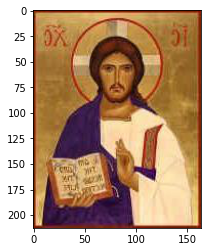

./data/caltech256/256_ObjectCategories/116.iguana/116_0084.jpg


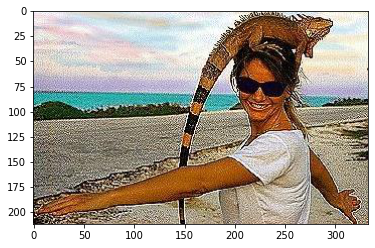

./data/caltech256/256_ObjectCategories/150.octopus/150_0059.jpg


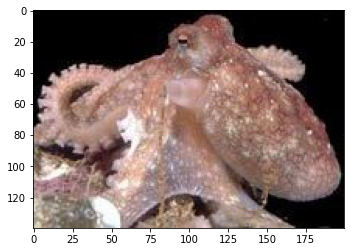

./data/caltech256/256_ObjectCategories/183.sextant/183_0029.jpg


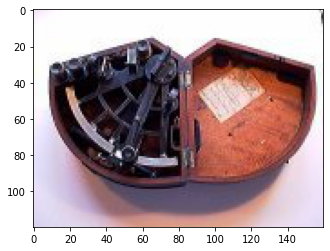

./data/caltech256/256_ObjectCategories/159.people/159_0130.jpg


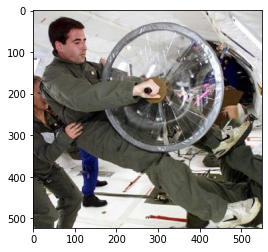

In [29]:
plot_similar_images(indices_list)